In [1]:
# Import necessary libraries
import logging
import pathlib
import re
from typing import Tuple, List
from collections import Counter

import gensim.downloader as api
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import sklearn.linear_model as linear_model
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import sklearn.svm as svm 
import sklearn.metrics as metrics
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
# Initialize logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [3]:
X_train_file = pathlib.Path("data/X_train_G3tdtEn.csv")
y_train_file = pathlib.Path("data/Y_train_2_XPXJDyy.csv")
X_test_file = pathlib.Path("data/X_test_8skS2ey.csv")

In [4]:
# Define the Word2Vec transformer class
class W2V(BaseEstimator, TransformerMixin):
    def __init__(self, num_words=None, **kwargs):
        self.num_words = num_words
        self.tokenizer = Tokenizer(num_words=num_words, **kwargs)

    def fit(self, X, y=None):
        self.Word2 = api.load("word2vec-google-news-300")
        return self

    def transform(self, X, y=None):
        x = np.array(X.values)
        for i in range(len(x)):
            for j in range(len(x[i])):
                tokens = x[i][j].split()
                embeddings = [
                    self.Word2[token]
                    for token in tokens
                    if token in self.Word2.key_to_index
                ]
                if len(embeddings) > 0:
                    mean = np.mean(embeddings)
                else:
                    mean = 0
                x[i][j] = mean
        return x

    def get_params(self, deep=True):
        return {"num_words": self.num_words}

In [5]:
def load_train_df(path: pathlib.Path) -> pd.DataFrame:
    mixed_columns = (
        ["item" + str(i) for i in range(1, 25)]
        + ["make" + str(i) for i in range(1, 25)]
        + ["model" + str(i) for i in range(1, 25)]
        + ["goods_code" + str(i) for i in range(1, 25)]
    )
    dtype = {col: str for col in mixed_columns}
    return pd.read_csv(path, dtype=dtype)


def load_test_df(path: pathlib.Path) -> pd.Series:
    return pd.read_csv(path)["fraud_flag"]

In [102]:
def df_to_input(df: pd.DataFrame) -> Tuple[pd.DataFrame, List[str], List[str]]:
    # Add feature columns
    df["total_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].sum(axis=1)
    df["avg_item_price"] = df["total_price"] / df["Nb_of_items"]
    df["max_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].max(axis=1)
    df["min_item_price"] = df[[f"cash_price{i}" for i in range(1, 25)]].min(axis=1)
    df["product_count"] = df[[f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]].sum(
        axis=1
    )
    df["nb_unique_makes"] = df[[f"make{i}" for i in range(1, 25)]].nunique(axis=1)
    df["nb_unique_models"] = df[[f"model{i}" for i in range(1, 25)]].nunique(axis=1)
    df["item_to_product_ratio"] = df["Nb_of_items"] / df["product_count"]
    df["price_variance"] = df[[f"cash_price{i}" for i in range(1, 25)]].var(axis=1)
    # Most common item in the purchase.
    df["most_common_item"] = df[
        [f"Nbr_of_prod_purchas{i}" for i in range(1, 25)]
    ].idxmax(axis=1)
    most_common_item = []
    for _, row in df.iterrows():
        match = re.search(r"(\d+)", row["most_common_item"])
        item_number = int(match.group(1))
        most_common_item.append(row[f"item{item_number}"])
    df["most_common_item"] = most_common_item
    df["most_common_item"] = df["most_common_item"].astype(str)

    all_goods = []
    for _, row in df.iterrows():
        for i in range(1, 25):
            all_goods.append(row[f"goods_code{i}"])
    goods_counter = Counter(all_goods)
    for index, row in df.iterrows():
        for i in range(1, 25):
            if isinstance(row[f"goods_code{i}"], str):
                df.at[index, f"goods_code{i}"] = goods_counter[row[f"goods_code{i}"]]
            else:
                df.at[index, f"goods_code{i}"] = 0
    df[["goods_code" + str(i) for i in range(1, 25)]] = df[
        ["goods_code" + str(i) for i in range(1, 25)]
    ].astype(int)
    to_drop = ["ID"] + ["goods_code" + str(i) for i in range(1, 25)]
    df = df.drop(to_drop, axis=1)

    # Identify the columns to apply RNN tokenization
    categorical_columns = ["make", "item", "model"]  # Add more columns as needed
    categorical_columns = [
        col + str(i) for col in categorical_columns for i in range(1, 25)
    ]
    categorical_columns.append("most_common_item")

    # Identify the categorical and numerical columns
    numerical_columns = [
        col for col in df.columns if col not in set(categorical_columns)
    ]

    # Clean data
    for col in categorical_columns:
        df[col] = df[col].fillna("")
    for col in numerical_columns:
        df[col] = df[col].fillna(0)

    return df, categorical_columns, numerical_columns

In [103]:
X_train_df = load_train_df(X_train_file)
y_train_df = load_test_df(y_train_file)

X_train_df, categorical_columns, numerical_columns = df_to_input(X_train_df)

In [104]:
# Define transformers
cat_pipeline = make_pipeline(W2V())
num_pipeline = make_pipeline(StandardScaler())

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipeline", cat_pipeline, categorical_columns),
        ("num_pipeline", num_pipeline, numerical_columns),
    ]
)

clf = RandomForestClassifier(random_state=0, 
                            #  min_samples_split=5,
                             max_depth=20,
                             n_estimators=400)

# Create the pipeline
pipeline = Pipeline(steps=[("preprocess", preprocessor), ("model", clf)])

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_df, y_train_df, test_size=0.2, stratify=y_train_df, random_state=0
)
print(y_train.value_counts()[1] / len(y_train))
print(y_test.value_counts()[1] / len(y_test))

param_grid = {
    "model__bootstrap": [True],
}

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

grid = GridSearchCV(
    pipeline,
    param_grid,
    scoring="average_precision",
    cv=sss,
    n_jobs=-1,
    verbose=True,
)

0.014212199590473111
0.014225670869705788


In [105]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-22T17:59:57.455025', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat_pipeline',
                                                  Pipeline(steps=[('w2v',
                                                                   W2V())]),
                                                  ['make1', 'make2', 'make3',
                                                   'make4', 'make5', 'make6',
                                                   'make7', 'make8', 'make9',
                                                   'make10', 'make11', 'make12',
                                                   'make13', 'make14', 'make15',
                                                   'make16', 'make17', 'make18',
                                                   'make19', 'make20', 'make21',
                                                   'make22', 'make23', 'make24',
                                                   'item1', 'item2', 'item3',
                                                   'item4',...
                                                   'cash_price16',
                                                   'cash_price17',
                                                   'cash_price18',
                                                   'cash_price19',
                                                   'cash_price20',
                                                   'cash_price21',
                                                   'cash_price22',
                                                   'cash_price23',
                                                   'cash_price24',
                                                   'Nbr_of_prod_purchas1',
                                                   'Nbr_of_prod_purchas2',
                                                   'Nbr_of_prod_purchas3',
                                                   'Nbr_of_prod_purchas4',
                                                   'Nbr_of_prod_purchas5',
                                                   'Nbr_of_prod_purchas6', ...])])),
                ('model',
                 RandomForestClassifier(max_depth=20, n_estimators=400,
                                        random_state=0))])

0.16854339957263237


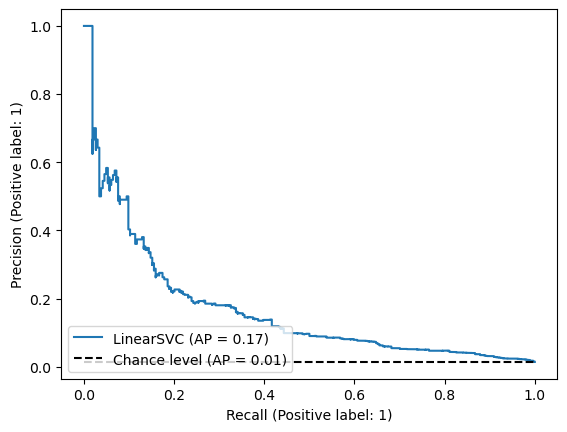

In [106]:
# print(grid.best_score_)
# print(grid.best_params_)
print(metrics.average_precision_score(y_test, pipeline.predict_proba(X_test)[:, 1]))
display = metrics.PrecisionRecallDisplay.from_estimator(
    pipeline, X_test, y_test, name="LinearSVC", plot_chance_level=True
)

In [94]:
out = pd.DataFrame(preprocessor.fit_transform(X_train, y_train), columns=categorical_columns + numerical_columns)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-22T16:22:15.663894', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


In [105]:
out["label"] = y_train
with pd.option_context(
    "display.max_rows", None, "display.max_columns", None
):  # more options can be specified also
    print(out.corr()["label"].abs().sort_values(ascending=False))
out[numerical_columns].describe()

label                    1.000000
goods_code17             0.016380
make16                   0.012376
cash_price12             0.012150
make15                   0.011737
make12                   0.009551
make8                    0.008996
goods_code13             0.008835
goods_code1              0.008516
make2                    0.008343
model13                  0.007413
model2                   0.006408
cash_price15             0.006301
max_item_price           0.006172
model17                  0.006157
cash_price1              0.005857
model16                  0.005762
model5                   0.005690
model4                   0.005283
item8                    0.005125
make5                    0.005033
model14                  0.005020
model15                  0.004998
goods_code2              0.004881
goods_code9              0.004871
total_price              0.004800
item11                   0.004490
Nbr_of_prod_purchas7     0.004474
cash_price13             0.004451
item7         

,cash_price1,cash_price2,cash_price3,cash_price4,cash_price5,cash_price6,cash_price7,cash_price8,cash_price9,cash_price10,...,Nb_of_items,total_price,avg_item_price,max_item_price,min_item_price,product_count,nb_unique_makes,nb_unique_models,item_to_product_ratio,price_variance
count,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,...,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04,7.423200e+04
mean,-5.347114e-17,-1.079234e-17,-3.436319e-17,2.503057e-17,-1.901223e-17,2.297261e-18,9.667639e-18,4.785960e-19,-6.269607e-18,2.392980e-19,...,2.862004e-17,-8.968889e-17,-1.573624e-16,3.405210e-17,4.827837e-17,1.191704e-17,-9.661656e-17,-1.014623e-17,-2.448976e-16,8.351500e-18
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.536638e+00,-3.205211e-01,-1.757806e-01,-1.076149e-01,-7.015200e-02,-5.918846e-02,-4.304653e-02,-4.007276e-02,-3.384498e-02,-3.227514e-02,...,-5.290064e-01,-1.322265e+00,-1.328087e+00,-1.533520e+00,-8.309514e-01,-4.293748e-01,-2.037157e+00,-1.378002e+00,-1.236476e+01,-3.843662e-01
25%,-6.251908e-01,-3.205211e-01,-1.757806e-01,-1.076149e-01,-7.015200e-02,-5.918846e-02,-4.304653e-02,-4.007276e-02,-3.384498e-02,-3.227514e-02,...,-5.290064e-01,-5.932394e-01,-6.833308e-01,-6.084692e-01,-8.163818e-01,-4.293748e-01,-6.002707e-01,-5.367102e-01,1.779225e-01,-3.843662e-01
50%,-2.025722e-01,-3.205211e-01,-1.757806e-01,-1.076149e-01,-7.015200e-02,-5.918846e-02,-4.304653e-02,-4.007276e-02,-3.384498e-02,-3.227514e-02,...,-5.290064e-01,-1.766533e-01,-2.425298e-01,-2.037596e-01,-3.289611e-01,-4.293748e-01,-6.002707e-01,-5.367102e-01,1.779225e-01,-3.843662e-01
75%,3.552844e-01,-1.999674e-01,-1.757806e-01,-1.076149e-01,-7.015200e-02,-5.918846e-02,-4.304653e-02,-4.007276e-02,-3.384498e-02,-3.227514e-02,...,1.617934e-01,3.440792e-01,3.975945e-01,3.223629e-01,5.584623e-01,7.153436e-02,8.366160e-01,3.045819e-01,1.779225e-01,5.494902e-02
max,2.944553e+01,2.206458e+01,3.905578e+01,6.325201e+01,6.312498e+01,7.232652e+01,1.229516e+02,1.185281e+02,1.027808e+02,8.781000e+01,...,4.022818e+01,2.702641e+01,3.299397e+01,3.014368e+01,2.830170e+01,4.815882e+01,2.382680e+01,1.881301e+01,1.834319e+01,4.940488e+01


In [45]:
print(grid.best_params_)
print(grid.best_score_)

{'model__max_depth': 20, 'model__n_estimators': 400}
0.18999914433325743


In [107]:
X_test_df = load_train_df(X_test_file)
X_test_df, _, _ = df_to_input(X_test_df)

In [55]:
best_params = {k.replace("model__", ""): v for k, v in grid.best_params_.items()}

In [61]:
best_params

{'max_depth': 20, 'n_estimators': 400}

In [108]:
full_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            RandomForestClassifier(
                random_state=0,
                #  min_samples_split=5,
                max_depth=20,
                n_estimators=400,
            ),
        ),
    ],
    verbose=True,
)

In [109]:
print(X_test_df.shape)
print(X_train_df.shape)

(23198, 131)
(92790, 131)


In [110]:
out = pipeline.fit(X_train_df, y_train_df).predict_proba(X_test_df)

INFO:gensim.models.keyedvectors:loading projection weights from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from /Users/charles/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-11-22T18:01:36.814883', 'gensim': '4.3.0', 'python': '3.10.13 (main, Sep 11 2023, 08:24:56) [Clang 14.0.6 ]', 'platform': 'macOS-14.0-arm64-arm-64bit', 'event': 'load_word2vec_format'}


In [111]:
out_ = out[:, 1]
IDs = pd.read_csv(X_test_file)["ID"]
df = pd.DataFrame({"ID": IDs, "fraud_flag": out_})
df = df.reset_index()
df.to_csv("out.csv", index=False)
df.describe()

/var/folders/m8/1pn02zvd5rn8khdmf1r7t7sc0000gn/T/ipykernel_10319/3316615219.py:2: DtypeWarning: Columns (20,21,22,23,24,68,69,70,71,72,92,93,94,95,96,97,106,107,108,109,110,111,112,113,114,115,116,117,118) have mixed types. Specify dtype option on import or set low_memory=False.
  IDs = pd.read_csv(X_test_file)["ID"]


,index,ID,fraud_flag
count,23198.000000,23198.000000,23198.000000
mean,11598.500000,58091.621605,0.014145
std,6696.830108,33465.131873,0.041615
min,0.000000,3.000000,0.000000
25%,5799.250000,29355.500000,0.000246
50%,11598.500000,58128.000000,0.001998
75%,17397.750000,87016.750000,0.014525
max,23197.000000,115987.000000,0.994084


In [ ]:
df["fraud_flag"].hist()